In [1]:
import numpy as np
from skimage import io, color, transform
from keras.models import model_from_json
from skimage import transform, util
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
im = io.imread('./sudoku_test_images/sudoku3.png')

# Convert to grayscale
im = color.rgb2gray(im)

# Reshape im (Rescale the input image, make it square)
target_size = int(np.mean(im.shape))
im = transform.resize(im, (target_size,)*2)
print 'im.shape:', im.shape

im.shape: (431, 431)


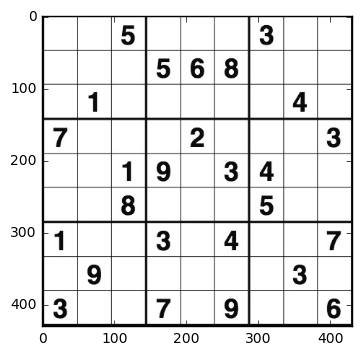

In [3]:
# Plot the image
plt.imshow(im, cmap='gray')

## Functions

In [4]:
def is_blank(im):
    """
        Returns whether the there is a digit or a blank image.
    """
    
    # Take the r% center
    r = 0.2
    h1 = int(float(im.shape[0]) * r)
    h2 = im.shape[0] - h1
    w1 = int(float(im.shape[1]) * r)   
    w2 = im.shape[1] - w1
    #
    im_center = im[h1:h2, w1:w2]
    
    if np.mean(im_center) < 0.06:
        return True
    else:
        return False
    

def fix_crop(im):
    """
        Centers the digit image
        
        Args:
            im: Cropped small digit image (It is assumed to have black bavk)
    """
    # Threshold the image and make it binary
    try:
        t = threshold_otsu(im)
    except ValueError:
        return im
    
    im_bw = im > t
    
    # Get the bounding box of the digit 
    true_i = np.where(im_bw == True)
    bbox = (np.min(true_i[0])-1, np.max(true_i[0])+1, np.min(true_i[1])-1, np.max(true_i[1])+1)
    
    # Fix
    im_crop = im[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    im_fixed = np.zeros(im.shape)
    # h
    h1 = (im_fixed.shape[0]/2) - (im_crop.shape[0]/2)
    h2 = h1 + (im_crop.shape[0]) 
    # w
    w1 = (im_fixed.shape[1]/2) - (im_crop.shape[1]/2)
    w2 = w1 + (im_crop.shape[1])
    im_fixed[h1:h2,w1:w2] = im_crop
    
    return im_fixed
   

def get_crops(im):
    """
        im: Whole sudoku image (It is assumed to have white background and black digits)
    """
    # Convert to grayscale
    im = color.rgb2gray(im)

    # Reshape im (Rescale the input image, make it perfect square)
    target_size = int(np.mean(im.shape))
    im = transform.resize(im, (target_size,)*2)
    
    # Size of the square
    sq_size = target_size / 9.0
    # Get the centers
    centers = np.linspace(0,target_size,9,endpoint=False) + sq_size / 2.0
    
    # Crop
    r = 0.71
    crop_size = int(round((sq_size * r) * 0.5))

    cropped_ims = []
    for i in range(9):
        for j in range(9):
            v1, v2 = centers[i] - crop_size, centers[i] + crop_size
            h1, h2 = centers[j] - crop_size, centers[j] + crop_size
            v1, v2, h1, h2 = int(round(v1)), int(round(v2)), int(round(h1)), int(round(h2))        
            cropped = im[v1:v2, h1:h2]
            
            # Process cropped_im
            cropped = 1.0 - cropped  # At this point, digit is white, background is black
            
            # Fix the cropped image (Place the digit to the center)
            cropped = fix_crop(cropped)
            
            # Append
            cropped_ims.append(cropped)
  
    return cropped_ims


def get_digit(im, model, input_shape=(128,128)):
    """
    im: Input Digit Image (Sudoku image is assumed to be black digits on a white background)
    model: model to predict the digit
    """
    
    # First check if it is blank
    if is_blank(im):
        return -1
    
    # Predict the digit using trained model
    im = transform.resize(im, input_shape)
    im = np.expand_dims(im, axis=0)
    im = np.expand_dims(im, axis=3)
    im = 1.0 - im  # Invert the grayscale so that ...
    return int(model.predict_classes(im, verbose=0)[0]) + 1  # +1 because it predicts 1 less due to order of classes

## Predict Sudoku

In [5]:
# * Load the model
# Load the architecture
json_file = file('./train_synthetic_digit/model_arch.txt', 'r')
json_str = json_file.read()
model_l = model_from_json(json_str)
# Load the weights
model_l.load_weights('./train_synthetic_digit/model_weights.h5')

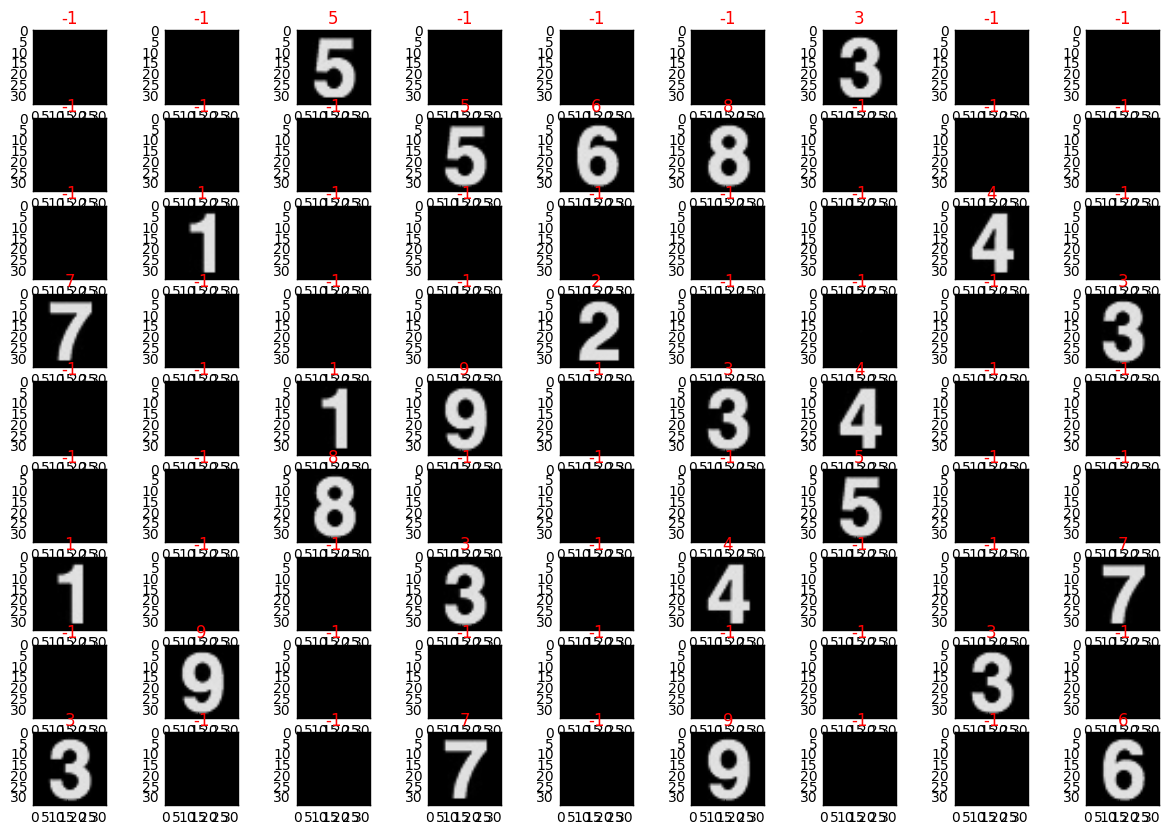

In [6]:
im = io.imread('./sudoku_test_images/sudoku3.png')
cropped_ims = get_crops(im)

sudoku_array = np.zeros((9,9), dtype=np.int)
# Plot the crops
fig = plt.figure()
fig.set_size_inches(15,10)
for i in range(9):
    for j in range(9):
        plt.subplot(9,9, 9 * i + j + 1)
        plt.imshow(cropped_ims[9 * i + j], cmap='gray', clim=(0.0, 1.0))
        plt.title(str(get_digit(cropped_ims[9 * i + j], model=model_l)), color='r')
        sudoku_array[i, j] = get_digit(cropped_ims[9 * i + j], model=model_l)

array([[ 0.38934177,  0.06913487,  0.09513283,  0.06434198,  0.12763102,
         0.04261739,  0.10677072,  0.04788432,  0.05714512]], dtype=float32)

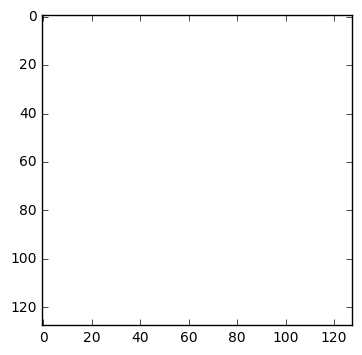

In [7]:
ex_im = cropped_ims[8]
ex_im = transform.resize(ex_im, (128, 128))
ex_im = 1.0 - ex_im

fig = plt.figure()
plt.imshow(ex_im, cmap='gray', clim=(0,1))

model_l.predict(ex_im.reshape(1,128,128,1))

In [17]:
im = io.imread('./sudoku_test_images/sudoku.png')
digits = [get_digit(im_crop, model_l) for im_crop in get_crops(im)]
sudoku_digits = np.array(digits).reshape(9, 9)
print sudoku_digits

[[ 5  3 -1 -1  7 -1 -1 -1 -1]
 [ 6 -1 -1  1  9  5 -1 -1 -1]
 [-1  9  8 -1 -1 -1 -1  6 -1]
 [ 8 -1 -1 -1  6 -1 -1 -1  3]
 [ 4 -1 -1  8 -1  3 -1 -1  1]
 [ 7 -1 -1 -1  2 -1 -1 -1  6]
 [-1  6 -1 -1 -1 -1  2  8 -1]
 [-1 -1 -1  4  1  9 -1 -1  5]
 [-1 -1 -1 -1  8 -1 -1  7  9]]
